In [ ]:
# This code trains the model on the CM ratios of chemicals in our database
# and tries to predict the CM ratios of new PFAS chemicals using the 
# Mordred parameters as inputs

In [1]:
# Import libraries
import numpy as np
import pandas as pd

In [2]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np
from sklearn.metrics import mean_absolute_error
print(tf.__version__)

2.3.0


In [3]:
# Read datasets
dataset = pd.read_csv('Non-LipidAdjusted_sigOnly.csv')
dataset = dataset.select_dtypes([np.number])

In [4]:
dataset

,Unnamed: 0,C:M Ratio Master,C:M Ratio Lipid Normalized,C:M Ratio Non-Lipid Normalized,# Total Atoms,# Atoms w/o Salt,FilterItLogS,PEOE_VSA6,EState_VSA9,NsCl,...,SssssC,ATS0pe,GATS1m,GATS1Z,ATS3are,BCUTdv-1h,ATS0s,ETA_epsilon_3,ATSC3i,ATSC4are
0,0,0.001276,0.004057,0.001276,22.0,22.0,-4.689533,17.288447,15.308119,0.0,...,-4.342906,288.8491,0.765047,0.769887,564.9990,7.014086,305.895833,0.433333,-30.901072,-3.803187
1,1,0.012264,0.039000,0.012264,20.0,20.0,-3.609705,0.000000,4.736863,0.0,...,0.000000,228.9683,0.867692,0.883020,501.2720,6.017822,215.243913,0.437931,-3.016147,-2.116486
2,2,0.019018,0.060477,0.019018,20.0,20.0,-3.562566,31.395199,4.736863,0.0,...,-0.558424,274.1313,1.060515,1.054556,714.8040,6.007457,129.645833,0.437931,-22.574335,0.554080
3,3,0.019040,0.060546,0.019040,54.0,54.0,-9.071417,74.511145,9.473726,0.0,...,0.000000,653.7920,0.812148,0.807016,1580.0348,6.029305,390.423525,0.440260,-25.848412,-2.334104
4,4,0.026178,0.083246,0.026178,24.0,24.0,-5.802049,18.199101,9.998755,0.0,...,-0.562471,277.8472,0.783113,0.782584,654.7130,7.004057,203.951389,0.441176,-13.861326,-1.324305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,259,4.099421,13.036158,4.099421,17.0,17.0,-3.501124,23.733674,16.707467,1.0,...,-0.478520,214.5469,0.712733,0.706422,504.9810,6.021927,152.984463,0.433333,-1.230345,-1.550612
260,260,6.694215,21.287603,6.694215,23.0,23.0,-4.344412,24.265468,10.213055,0.0,...,-15.666875,264.6471,0.575175,0.587741,539.1600,7.017330,513.798611,0.437313,-82.473729,13.552507
261,261,11.888889,37.806667,11.888889,24.0,24.0,-5.469447,0.000000,0.000000,0.0,...,0.000000,302.3893,0.981190,0.975154,694.7840,6.021954,155.888889,0.437143,48.628331,-1.359158
262,262,13.888889,44.166667,13.888889,13.0,13.0,-1.240852,12.132734,5.106527,0.0,...,0.000000,144.5769,0.698827,0.694761,234.2200,6.028527,185.361111,0.433333,-10.838468,-2.598458


In [5]:
datasetR1 = dataset.loc[:, 'FilterItLogS':'ATSC4are']
datasetR2 = dataset.loc[:, 'C:M Ratio Lipid Normalized':'C:M Ratio Non-Lipid Normalized']

In [6]:
df_PFAS = pd.read_csv('df_mordred_PFAS_MasterList.csv')
df_PFAS = df_PFAS.select_dtypes([np.number])
df_PFAS = df_PFAS.loc[:, df_PFAS.columns.isin(datasetR1.columns)]

C:\Users\Adi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (145,146,147,154,155,156,163,164,165,172,173,174,181,182,183,190,191,192,199,200,201,208,209,210,217,218,219,226,227,228,235,236,237,240,241,242,243,244,245,246,247,248,348,349,350,351,352,353,361,362,363,370,371,372,379,380,381,388,389,390,397,398,399,406,407,408,415,416,417,424,425,426,433,434,435,442,443,444,451,452,453,456,457,458,459,460,467,468,469,475,476,477,483,484,485,491,492,493,499,500,501,507,508,509,515,516,517,523,524,525,531,532,533,539,540,541,547,548,549,552,553,554,555,556,563,564,565,571,572,573,579,580,581,587,588,589,595,596,597,603,604,605,611,612,613,619,620,621,627,628,629,635,636,637,643,644,645,648,649,822,823,877,878,893,894,1115,1134,1194,1213,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1289,1292,1294,1584) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, res

In [7]:
datasetR1 = datasetR1.loc[:, datasetR1.columns.isin(df_PFAS.columns)]

In [8]:
df_PFAS.shape, datasetR1.shape

((7986, 444), (264, 444))

In [9]:
count_nan = len(dataset) - dataset.count()
count_nan.sum()

80

In [10]:
df_PFAS = df_PFAS.reindex(sorted(df_PFAS.columns), axis=1)
datasetR1 = datasetR1.reindex(sorted(datasetR1.columns), axis=1)

In [11]:
dataset = pd.concat([datasetR1, datasetR2], axis=1)

In [12]:
dataset.shape

(264, 446)

In [13]:
dataset['C:M Ratio Lipid Normalized'] = dataset['C:M Ratio Lipid Normalized'].replace(0, 0.01)
dataset['logCM'] = np.log10(dataset['C:M Ratio Lipid Normalized'])

In [14]:
dataset['C:M Ratio Non-Lipid Normalized'] = dataset['C:M Ratio Non-Lipid Normalized'].replace(0, 0.01)
dataset['logCM_non_adjusted'] = np.log10(dataset['C:M Ratio Non-Lipid Normalized'])

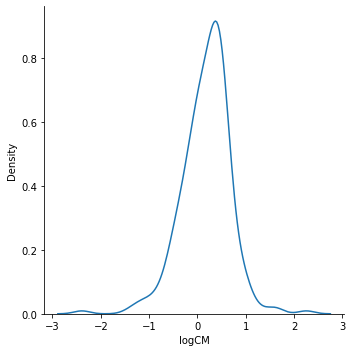

In [15]:
import seaborn as sns
sns.displot(dataset, x='logCM',kind ='kde')

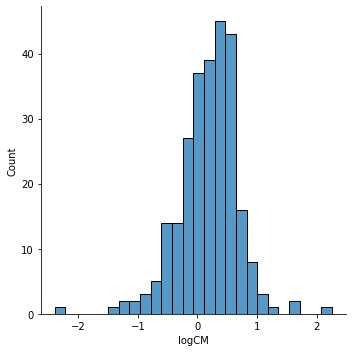

In [16]:
import seaborn as sns
sns.displot(dataset, x='logCM')

In [17]:
# Rhow dataframe column names
dataset.columns.values

array(['AATS0d', 'AATS0dv', 'AATS0i', 'AATS0p', 'AATS0s', 'AATS0v',
       'AATS1i', 'AATS1p', 'AATS1s', 'AATS1v', 'AATS2d', 'AATS2i',
       'AATS2p', 'AATS2s', 'AATS2v', 'AATSC0are', 'AATSC0dv', 'AATSC0i',
       'AATSC0s', 'AATSC1are', 'AATSC1i', 'AATSC1pe', 'AATSC1s',
       'AATSC1se', 'AATSC2dv', 'ABC', 'ABCGG', 'AETA_alpha',
       'AETA_beta_ns_d', 'AETA_eta', 'AMID_O', 'AMID_X', 'AMW', 'ATS0d',
       'ATS0p', 'ATS0pe', 'ATS0s', 'ATS0se', 'ATS0v', 'ATS1Z', 'ATS1are',
       'ATS1d', 'ATS1i', 'ATS1m', 'ATS1p', 'ATS1pe', 'ATS1se', 'ATS1v',
       'ATS2Z', 'ATS2are', 'ATS2d', 'ATS2i', 'ATS2m', 'ATS2p', 'ATS2pe',
       'ATS2se', 'ATS2v', 'ATS3Z', 'ATS3are', 'ATS3d', 'ATS3i', 'ATS3m',
       'ATS3p', 'ATS3pe', 'ATS3se', 'ATS3v', 'ATS4Z', 'ATS4d', 'ATS4i',
       'ATS4p', 'ATS4pe', 'ATS4se', 'ATS4v', 'ATS5Z', 'ATS5d', 'ATS5i',
       'ATS5m', 'ATS5p', 'ATS5pe', 'ATS5se', 'ATS5v', 'ATS6Z', 'ATS6are',
       'ATS6d', 'ATS6i', 'ATS6m', 'ATS6p', 'ATS6pe', 'ATS6se', 'ATS6v',
       'ATS

In [18]:
dataset.head()

,AATS0d,AATS0dv,AATS0i,AATS0p,AATS0s,AATS0v,AATS1i,AATS1p,AATS1s,AATS1v,...,piPC4,piPC5,piPC6,piPC7,piPC8,piPC9,C:M Ratio Lipid Normalized,C:M Ratio Non-Lipid Normalized,logCM,logCM_non_adjusted
0,2.813953,8.790698,174.168154,1.297849,7.113857,196.652420,151.785300,1.633599,3.411499,243.274313,...,4.563045,5.020998,5.243729,5.550048,5.311665,5.240092,0.004057,0.001276,-2.391750,-2.894178
1,3.277778,7.790123,158.603687,1.664726,5.978998,230.900938,141.423064,2.017247,2.958125,280.126392,...,5.032071,5.546641,5.773386,5.985352,6.010501,6.078502,0.039000,0.012264,-1.408935,-1.911363
2,2.702128,4.382979,164.477091,1.317282,2.758422,185.428599,146.235225,1.684363,2.554977,235.190392,...,4.514972,4.982322,4.990433,5.190523,5.250964,5.003946,0.060477,0.019018,-1.218410,-1.720837
3,3.000000,6.176532,163.486040,1.529220,3.648818,210.904879,147.191348,1.824080,2.781810,255.792585,...,5.546641,5.771052,5.685279,5.834811,6.048258,6.110081,0.060546,0.019040,-1.217912,-1.720339
4,3.266667,7.288889,162.903182,1.521963,4.532253,222.292440,144.301536,1.858094,3.098109,268.502499,...,5.208119,5.756533,6.033086,6.430072,6.682109,6.881828,0.083246,0.026178,-1.079636,-1.582063


In [19]:
# Assign X and y variables
X = dataset.loc[:, 'AATS0d':'piPC9'].values
y = dataset.loc[:, 'logCM_non_adjusted'].values

In [ ]:
# y-randomization step -  use only for y-randomization analyis (to use remove '#')
#from sklearn.utils import shuffle
#y = shuffle(y, random_state=1)

In [20]:
for i in range(25):    
    # Split dataframe into training and testing set
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

    
    # Normalize data
    from sklearn.preprocessing import StandardScaler

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # Compile the ANN model
    def build_model():
        model = keras.Sequential([
        keras.layers.Flatten(input_shape=(X_train.shape[1],)),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(100, activation='exponential'),
        keras.layers.Dense(1)
      ])

        optimizer = tf.optimizers.Adamax(0.001)

        model.compile(loss='mae',
                    optimizer=optimizer,
                    metrics=['mae'])
        return model

    model = build_model()
    #model.summary()

    # Display training progress by printing a single dot for each completed epoch
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')

    EPOCHS = 500

    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=150)

    history = model.fit(X_train, y_train, epochs=EPOCHS,
                        validation_split=0.2, verbose=0,
                        callbacks=[early_stop, PrintDot()])

    # Export data into a dataframe
    import pandas as pd
    # Use model to predict data for training set
    from sklearn import metrics
    y_pred = model.predict(X_train).flatten()
    
    df = pd.DataFrame({'predicted_values':y_pred, 'true_values':y_train})
    print(df.head())

    # Print data to a csv file
    df.to_csv('ANN_plus_tr_' + str(i) + '.csv')
    
    PFAS_X_test = df_PFAS.values
    
    PFAS_X_test = sc.transform(PFAS_X_test)
    # Use model to make predictions for PFAS
    y_pred = model.predict(PFAS_X_test).flatten()

    # Export data into a dataframe
    df = pd.DataFrame({'predicted_values':y_pred})
    print(df.head())

    # Print dataframe
    df.to_csv('ANN_plus_ts_' + str(i) + '.csv')


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.......   predicted_values  true_values
0          0.193182     0.178977
1         -0.045434    -0.033858
2         -0.152333    -0.131581
3         -0.029205    -0.021325
4         -0.531191    -0.460000
   predicted_values
0          0.151383
1          0.033134
2          0.227615
3          0.072927
4          0.050354

....................................................................................................
...................................................................   predicted_values  true_values
0         -0.269396    -0.240893
1          0.142737     0.165459
2 

In [22]:
#Summarize results into one csv file
ts1 = pd.read_csv('ANN_plus_ts_0.csv')
ts2 = pd.read_csv('ANN_plus_ts_1.csv')
ts3 = pd.read_csv('ANN_plus_ts_2.csv')
ts4 = pd.read_csv('ANN_plus_ts_3.csv')
ts5 = pd.read_csv('ANN_plus_ts_4.csv')

ts6 = pd.read_csv('ANN_plus_ts_5.csv')
ts7 = pd.read_csv('ANN_plus_ts_6.csv')
ts8 = pd.read_csv('ANN_plus_ts_7.csv')
ts9 = pd.read_csv('ANN_plus_ts_8.csv')
ts10 = pd.read_csv('ANN_plus_ts_9.csv')

ts11 = pd.read_csv('ANN_plus_ts_10.csv')
ts12 = pd.read_csv('ANN_plus_ts_11.csv')
ts13 = pd.read_csv('ANN_plus_ts_12.csv')
ts14 = pd.read_csv('ANN_plus_ts_13.csv')
ts15 = pd.read_csv('ANN_plus_ts_14.csv')

ts16 = pd.read_csv('ANN_plus_ts_15.csv')
ts17 = pd.read_csv('ANN_plus_ts_16.csv')
ts18 = pd.read_csv('ANN_plus_ts_17.csv')
ts19 = pd.read_csv('ANN_plus_ts_18.csv')
ts20 = pd.read_csv('ANN_plus_ts_19.csv')

ts21 = pd.read_csv('ANN_plus_ts_20.csv')
ts22 = pd.read_csv('ANN_plus_ts_21.csv')
ts23 = pd.read_csv('ANN_plus_ts_22.csv')
ts24 = pd.read_csv('ANN_plus_ts_23.csv')
ts25 = pd.read_csv('ANN_plus_ts_24.csv')
ts = pd.concat([ts1,ts2,ts3,ts4,ts5, 
                ts6,ts7,ts8,ts9,ts10, 
                ts11,ts12,ts13,ts14,ts15,
                ts16,ts17,ts18,ts19,ts20,
                ts21,ts22,ts23,ts24,ts25], axis=1)
ts = ts['predicted_values']

tr1 = pd.read_csv('ANN_plus_tr_0.csv')
tr2 = pd.read_csv('ANN_plus_tr_1.csv')
tr3 = pd.read_csv('ANN_plus_tr_2.csv')
tr4 = pd.read_csv('ANN_plus_tr_3.csv')
tr5 = pd.read_csv('ANN_plus_tr_4.csv')

tr6 = pd.read_csv('ANN_plus_tr_5.csv')
tr7 = pd.read_csv('ANN_plus_tr_6.csv')
tr8 = pd.read_csv('ANN_plus_tr_7.csv')
tr9 = pd.read_csv('ANN_plus_tr_8.csv')
tr10 = pd.read_csv('ANN_plus_tr_9.csv')

tr11 = pd.read_csv('ANN_plus_tr_10.csv')
tr12 = pd.read_csv('ANN_plus_tr_11.csv')
tr13 = pd.read_csv('ANN_plus_tr_12.csv')
tr14 = pd.read_csv('ANN_plus_tr_13.csv')
tr15 = pd.read_csv('ANN_plus_tr_14.csv')

tr16 = pd.read_csv('ANN_plus_tr_15.csv')
tr17 = pd.read_csv('ANN_plus_tr_16.csv')
tr18 = pd.read_csv('ANN_plus_tr_17.csv')
tr19 = pd.read_csv('ANN_plus_tr_18.csv')
tr20 = pd.read_csv('ANN_plus_tr_19.csv')

tr21 = pd.read_csv('ANN_plus_tr_20.csv')
tr22 = pd.read_csv('ANN_plus_tr_21.csv')
tr23 = pd.read_csv('ANN_plus_tr_22.csv')
tr24 = pd.read_csv('ANN_plus_tr_23.csv')
tr25 = pd.read_csv('ANN_plus_tr_24.csv')
tr = pd.concat([tr1,tr2,tr3,tr4,tr5, 
                tr6,tr7,tr8,tr9,tr10, 
                tr11,tr12,tr13,tr14,tr15,
                tr16,tr17,tr18,tr19,tr20,
                tr21,tr22,tr23,tr24,tr25], axis=1)
tr = tr['predicted_values']


ts.to_csv('ANN_plus_ts.csv')
tr.to_csv('ANN_plus_tr.csv')

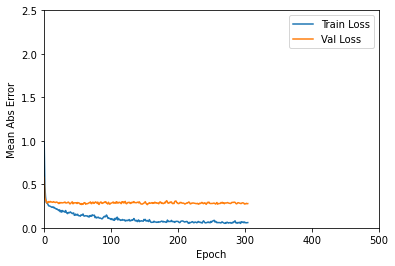

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot()
ax.plot(history.epoch, np.array(history.history['mae']),
           label='Train Loss')
ax.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.legend()
plt.ylim([0, 2.5])
plt.xlim([0, 500])
plt.show()
#fig.savefig('train_val_entact_500_20.png', dpi=400)


....................................................................

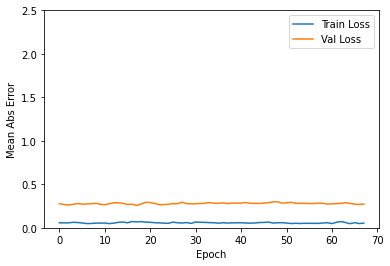

In [24]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

fig = plt.figure()
ax = plt.subplot()
ax.plot(history.epoch, np.array(history.history['mae']),
           label='Train Loss')
ax.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.legend()
plt.ylim([0, 2.5])
plt.show()
#fig.savefig('train_val_entact_20.png', dpi=400)

In [27]:
# Use model to predict data for training set
from sklearn import metrics

y_pred = model.predict(X_train).flatten()

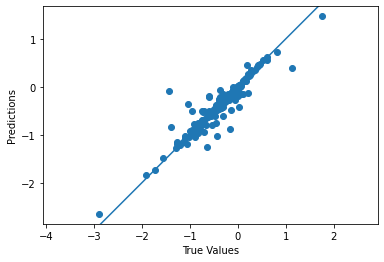

In [28]:
# Compare the true values vs the predicted values for the train set
plt.scatter(y_train, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

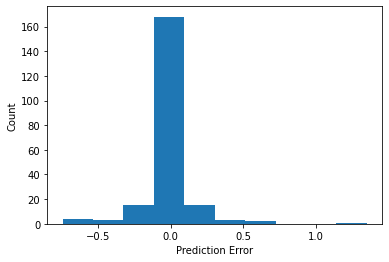

In [29]:
# Distribution of errors in the train set 
error = y_pred - y_train
plt.hist(error, bins = 10)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [33]:
# Export data into a dataframe
import pandas as pd
df = pd.DataFrame({'true_values':y_train,'predicted_values':y_pred})
print(df.head())

   true_values  predicted_values
0    -0.854610         -0.847536
1    -0.744952         -0.513025
2    -1.720837         -1.733350
3    -0.107313         -0.103706
4    -0.025306         -0.071105


In [34]:
#Print data to a csv file
#df.to_csv('ANN_plus_tr.csv')

In [35]:
from sklearn.metrics import r2_score
r2_score(y_train, y_pred)

0.8756248427402169

In [36]:
# Use model to make predictions for the testing set
y_pred = model.predict(X_test).flatten()

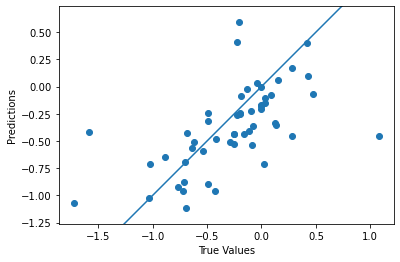

In [37]:
# Compare the true values vs the predicted values for the test set
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

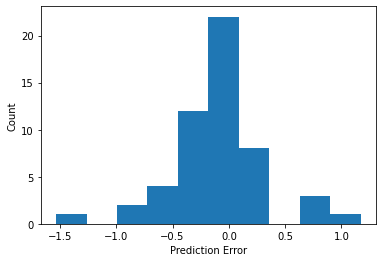

In [38]:
# Plot the distribution of errors in the testing set
error = y_pred - y_test
plt.hist(error, bins = 10)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [ ]:
# Export data into a dataframe
df = pd.DataFrame({'true_values':y_test,'predicted_values':y_pred})
print(df.head())

In [39]:
#Print dataframe
#df.to_csv('ANN_plus_ts.csv')

In [ ]:
r2_score(y_test, y_pred)

In [ ]:
PFAS_X_test = df_PFAS.values

In [ ]:
df_PFAS.columns

In [ ]:
PFAS_X_test = sc.transform(PFAS_X_test)

In [ ]:
# Use model to make predictions for PFAS
y_pred = model.predict(PFAS_X_test).flatten()

In [ ]:
y_pred

In [ ]:
pd.DataFrame(y_pred).to_csv("y_pred_ANN.csv")